In [1]:
!pip install deap tensorflow scikit-learn matplotlib numpy pandas seaborn

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, classification_report
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Load dataset
df = pd.read_csv('C:/Users/Arafath/Downloads/diabetes_data_upload.csv')  # Update path as needed
binary_cols = ['Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss', 
               'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 
               'Itching', 'Irritability', 'delayed healing', 'partial paresis',
               'muscle stiffness', 'Alopecia', 'Obesity', 'class']
df[binary_cols] = df[binary_cols].replace({'No':0, 'no':0, 'Yes':1, 'yes':1, 
                                          'Male':1, 'Female':0, 'Positive':1, 'Negative':0})

X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data loaded successfully!")
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

Data loaded successfully!
Training shape: (364, 16), Test shape: (156, 16)


C:\Users\Arafath\AppData\Local\Temp\ipykernel_9256\2114286579.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[binary_cols] = df[binary_cols].replace({'No':0, 'no':0, 'Yes':1, 'yes':1,


In [5]:
# Create fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Attribute generators
toolbox.register("attr_EnDeN", random.randint, 1, 3)  # 1-3 encoders/decoders
toolbox.register("attr_EnDeHLN", random.randint, 5, 100)  # 5-100 hidden units
toolbox.register("attr_EnAF", random.randint, 1, 2)  # 1=sigmoid, 2=tanh
toolbox.register("attr_DeAF", random.randint, 1, 3)  # 1=sigmoid, 2=tanh, 3=linear
toolbox.register("attr_L2WR", random.uniform, 0.001, 0.01)
toolbox.register("attr_SPR", random.randint, 1, 5)
toolbox.register("attr_SPP", random.uniform, 0, 1)
toolbox.register("attr_SD", random.randint, 1, 2)  # 1=True, 2=False

# Structure initializers
toolbox.register("individual", tools.initCycle, creator.Individual, 
                (toolbox.attr_EnDeN, toolbox.attr_EnDeHLN, toolbox.attr_EnAF,
                 toolbox.attr_DeAF, toolbox.attr_L2WR, toolbox.attr_SPR,
                 toolbox.attr_SPP, toolbox.attr_SD), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

print("DEAP framework initialized successfully!")

DEAP framework initialized successfully!


In [7]:
def evaluate(individual):
    # Clear any existing Keras session
    from tensorflow.keras import backend as K
    K.clear_session()
    
    # Decode individual
    EnDeN, EnDeHLN = int(individual[0]), int(individual[1])
    EnAF = 'sigmoid' if int(individual[2]) == 1 else 'tanh'
    DeAF = ['sigmoid', 'tanh', 'linear'][int(individual[3])-1]
    L2WR, SPR, SPP = individual[4], individual[5], individual[6]
    SD = bool(int(individual[7])-1)
    
    # Build autoencoder
    input_layer = Input(shape=(X_train.shape[1],))
    encoded = input_layer
    for _ in range(EnDeN):
        encoded = Dense(EnDeHLN, activation=EnAF, 
                       kernel_regularizer=regularizers.l2(L2WR))(encoded)
    decoded = encoded
    for _ in range(EnDeN):
        decoded = Dense(X_train.shape[1], activation=DeAF)(decoded)
    
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, verbose=0)
    
    # Build classifier
    encoder = Model(input_layer, encoded)
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    classifier = Sequential()
    classifier.add(Dense(2, activation='softmax', input_dim=EnDeHLN))
    classifier.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
    classifier.fit(X_train_encoded, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Evaluate
    _, test_acc = classifier.evaluate(X_test_encoded, y_test, verbose=0)
    return test_acc,

toolbox.register("evaluate", evaluate)
print("Evaluation function registered!")

Evaluation function registered!


In [9]:
# Custom mutation function
def mutMixed(individual, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            if i in [0, 1, 2, 3, 5, 7]:  # Integer genes
                if i == 0: individual[i] = random.randint(1, 3)
                elif i == 1: individual[i] = random.randint(5, 100)
                elif i == 2: individual[i] = random.randint(1, 2)
                elif i == 3: individual[i] = random.randint(1, 3)
                elif i == 5: individual[i] = random.randint(1, 5)
                elif i == 7: individual[i] = random.randint(1, 2)
            else:  # Float genes
                if i == 4: individual[i] = random.uniform(0.001, 0.01)
                elif i == 6: individual[i] = random.uniform(0, 1)
    return individual,

# Register genetic operators
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutMixed, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)

# Statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("std", np.std)

print("Genetic operators configured!")

Genetic operators configured!


In [19]:
# Parameters
POP_SIZE = 20
GEN = 20
CXPB = 0.85
MUTPB = 0.03

# Initialize
population = toolbox.population(n=POP_SIZE)
hof = tools.HallOfFame(1)

# Run GA
print(f"Starting GA with {POP_SIZE} individuals for {GEN} generations...")
pop, log = algorithms.eaSimple(population, toolbox, cxpb=CXPB, mutpb=MUTPB,
                              ngen=GEN, halloffame=hof, stats=stats, verbose=True)

# Results
best = hof[0]
print("\nBest Individual:")
print(f"Layers: {int(best[0])}, Units: {int(best[1])}")
print(f"Encoder: {'sigmoid' if int(best[2])==1 else 'tanh'}")
print(f"Decoder: {['sigmoid','tanh','linear'][int(best[3])-1]}")
print(f"L2: {best[4]:.4f}, SPR: {best[5]}, SPP: {best[6]:.2f}")
print(f"Scale: {bool(best[7])}")
print(f"Accuracy: {best.fitness.values[0]*100:.2f}%")

Starting GA with 20 individuals for 20 generations...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


C:\Users\Arafath\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━

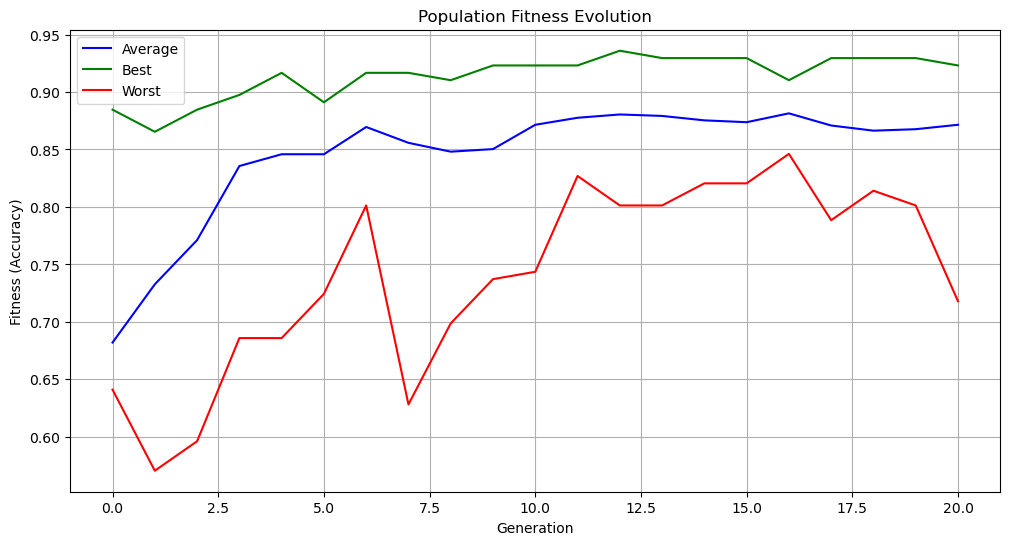

In [21]:
# Plot evolution
plt.figure(figsize=(12,6))
plt.plot(log.select('gen'), log.select('avg'), 'b-', label="Average")
plt.plot(log.select('gen'), log.select('max'), 'g-', label="Best")
plt.plot(log.select('gen'), log.select('min'), 'r-', label="Worst")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.title("Population Fitness Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Build final model with best parameters
best = hof[0]
input_layer = Input(shape=(X_train.shape[1],))
encoded = Dense(int(best[1]), activation='sigmoid' if int(best[2])==1 else 'tanh',
               kernel_regularizer=regularizers.l2(best[4]))(input_layer)
decoded = Dense(X_train.shape[1], activation=['sigmoid','tanh','linear'][int(best[3])-1])(encoded)
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, verbose=1)

# Classifier
encoder = Model(input_layer, encoded)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

classifier = Sequential([
    Dense(2, activation='softmax', input_dim=int(best[1]))
])
classifier.compile(optimizer=Adam(learning_rate=0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
classifier.fit(X_train_encoded, y_train, epochs=200, batch_size=32, verbose=1)

# Evaluation
y_pred = classifier.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_classes))

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5626  
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3366 
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2694 
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2311 
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2029 
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1789 
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1600 
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1460 
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1251 
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1160 
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1080 
Epoch 13/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1006 
Epoch 14/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0956 
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

C:\Users\Arafath\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3936 - loss: 0.7413  
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4516 - loss: 0.7092 
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5936 - loss: 0.6724 
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6283 - loss: 0.6519 
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6446 - loss: 0.6267 
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6457 - loss: 0.6117 
Epoch 7/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7162 - loss: 0.5918 
Epoch 8/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.5823 
Epoch 9/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6692 - loss: 0.5791 
Epoch 10/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7055 - loss: 0.5596 
Epoch 11/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7494 - loss: 0.5300 
Epoch 12/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy:

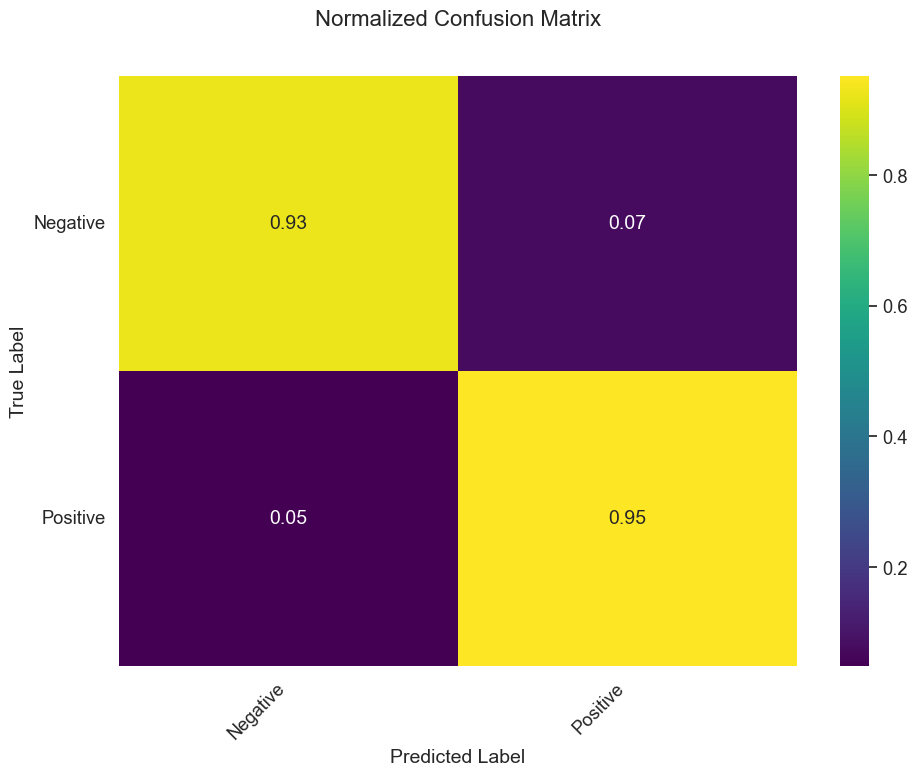

In [37]:
# Enhanced Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='viridis', 
            cbar=True, annot_kws={'size':14},
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix\n', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

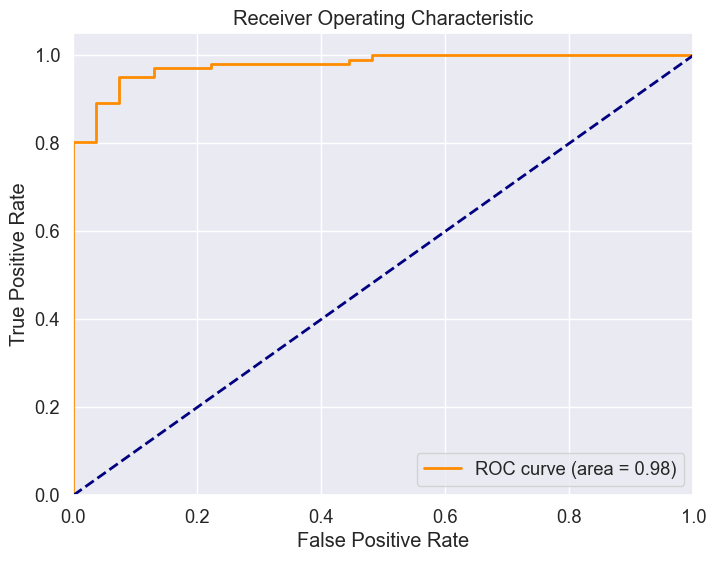

In [41]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

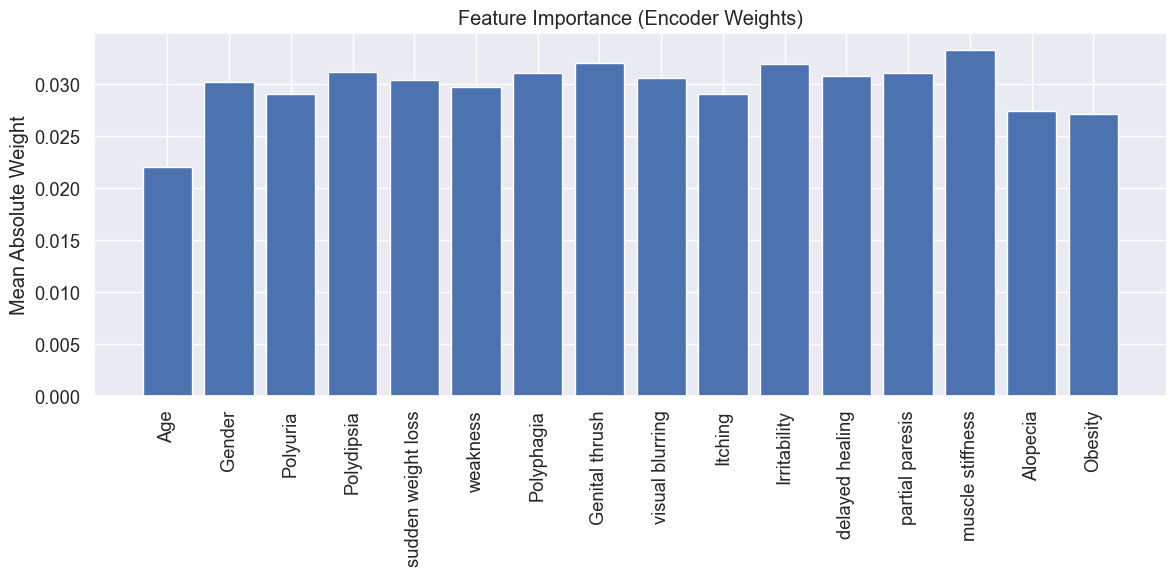

In [49]:
# Feature Importance from Encoder Weights
encoder_weights = encoder.layers[1].get_weights()[0]
importance = np.mean(np.abs(encoder_weights), axis=1)
features = X.columns

plt.figure(figsize=(12,6))
plt.bar(range(len(features)), importance)
plt.xticks(range(len(features)), features, rotation=90)
plt.title('Feature Importance (Encoder Weights)')
plt.ylabel('Mean Absolute Weight')
plt.tight_layout()
plt.show()

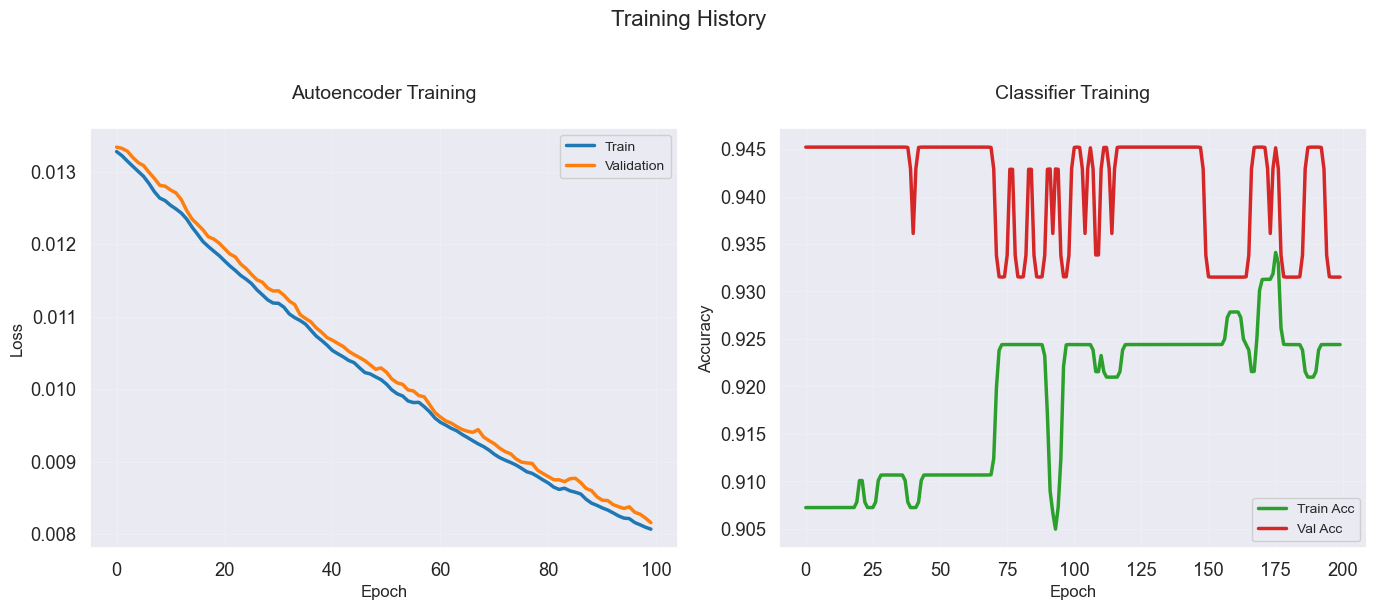

In [51]:
# Enhanced Training History with Smoothing
from scipy.ndimage import gaussian_filter1d

def smooth(scalars, weight=0.6):
    return gaussian_filter1d(scalars, sigma=weight)

plt.figure(figsize=(14,6))

# Autoencoder Loss
plt.subplot(1,2,1)
plt.plot(smooth(history.history['loss']), '#1f77b4', lw=2.5, label='Train')
plt.plot(smooth(history.history['val_loss']), '#ff7f0e', lw=2.5, label='Validation')
plt.title('Autoencoder Training\n', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.2)

# Classifier Accuracy
plt.subplot(1,2,2)
plt.plot(smooth(history_clf.history['accuracy']), '#2ca02c', lw=2.5, label='Train Acc')
plt.plot(smooth(history_clf.history['val_accuracy']), '#d62728', lw=2.5, label='Val Acc')
plt.title('Classifier Training\n', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.2)

plt.suptitle('Training History', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

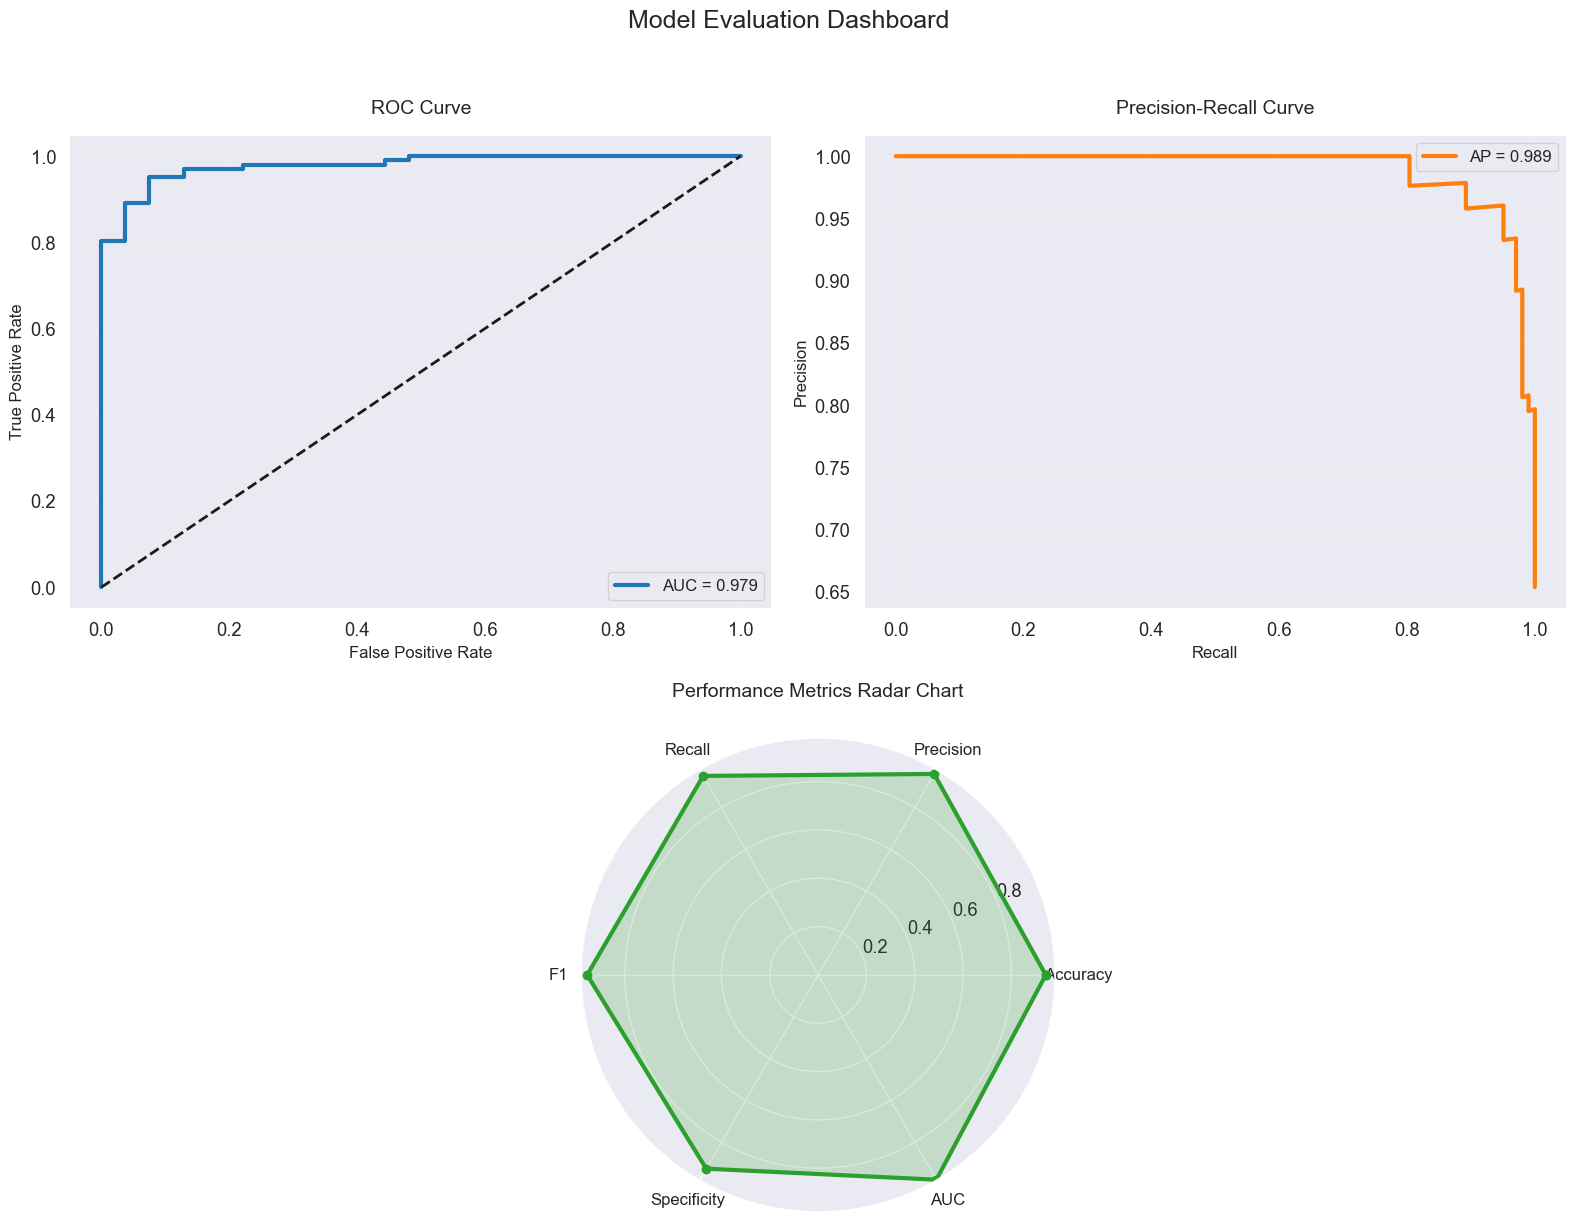

In [53]:
# Enhanced Metrics Dashboard
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16,12))
gs = GridSpec(2, 2, figure=fig)

# ROC Curve
ax1 = fig.add_subplot(gs[0,0])
fpr, tpr, _ = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='#1f77b4', lw=3, label=f'AUC = {roc_auc:.3f}')
ax1.plot([0,1],[0,1],'k--',lw=2)
ax1.set_title('ROC Curve', fontsize=14, pad=15)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.legend(loc='lower right', fontsize=12)
ax1.grid(True, alpha=0.2)

# Precision-Recall Curve
ax2 = fig.add_subplot(gs[0,1])
precision, recall, _ = precision_recall_curve(y_test, y_pred[:,1])
avg_precision = average_precision_score(y_test, y_pred[:,1])
ax2.plot(recall, precision, color='#ff7f0e', lw=3, 
         label=f'AP = {avg_precision:.3f}')
ax2.set_title('Precision-Recall Curve', fontsize=14, pad=15)
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.legend(loc='upper right', fontsize=12)
ax2.grid(True, alpha=0.2)

# Metrics Radar Chart
ax3 = fig.add_subplot(gs[1,:], polar=True)
metrics = ['Accuracy','Precision','Recall','F1','Specificity','AUC']
values = [
    accuracy_score(y_test, y_pred_classes),
    precision_score(y_test, y_pred_classes),
    recall_score(y_test, y_pred_classes),
    f1_score(y_test, y_pred_classes),
    recall_score(1-y_test, 1-y_pred_classes),  # Specificity
    roc_auc
]
values += values[:1]  # Close the radar chart
angles = np.linspace(0, 2*np.pi, len(metrics)+1)[:-1]
angles = np.append(angles, angles[0])

ax3.plot(angles, values, 'o-', color='#2ca02c', lw=3)
ax3.fill(angles, values, color='#2ca02c', alpha=0.2)
ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(metrics, fontsize=12)
ax3.set_title('Performance Metrics Radar Chart', fontsize=14, pad=30)
ax3.grid(True)

plt.suptitle('Model Evaluation Dashboard', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


               FINAL MODEL EVALUATION REPORT                
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Metric,Value
0,Accuracy,0.9423
1,Precision,0.9604
2,Recall (Sensitivity),0.9510
3,Specificity,0.9259
4,F1-Score,0.9557
5,ROC AUC,0.9768
6,True Positives,97
7,True Negatives,50
8,False Positives,4
9,False Negatives,5



------------------------------------------------------------
              Detailed Classification Report:               
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92        54
    Positive       0.96      0.95      0.96       102

    accuracy                           0.94       156
   macro avg       0.93      0.94      0.94       156
weighted avg       0.94      0.94      0.94       156



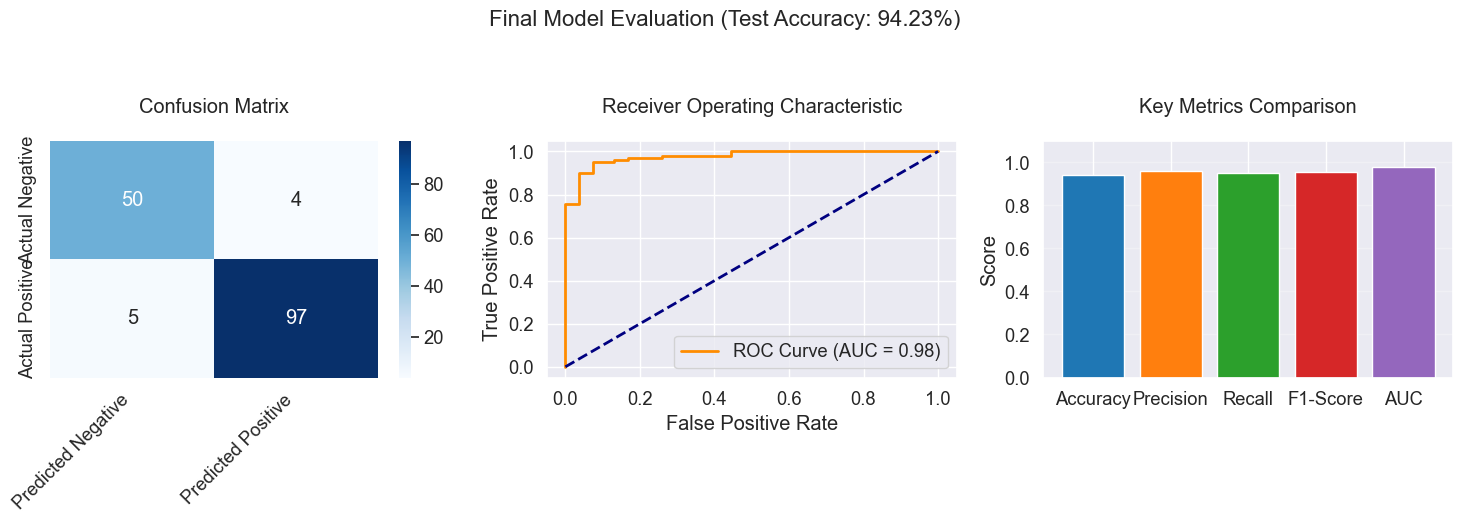


                    EVALUATION COMPLETE                     


In [59]:
# Cell 14: Comprehensive Final Evaluation Report
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

print("\n" + "="*60)
print("FINAL MODEL EVALUATION REPORT".center(60))
print("="*60)

# Calculate all metrics
y_pred_proba = classifier.predict(X_test_encoded)
y_pred = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])

# Create metric table
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'Specificity', 
               'F1-Score', 'ROC AUC', 'True Positives', 'True Negatives',
               'False Positives', 'False Negatives'],
    'Value': [f"{accuracy:.4f}", f"{precision:.4f}", f"{recall:.4f}",
              f"{cm[0,0]/(cm[0,0]+cm[0,1]):.4f}", f"{f1:.4f}", f"{roc_auc:.4f}",
              f"{cm[1,1]}", f"{cm[0,0]}", f"{cm[0,1]}", f"{cm[1,0]}"]
})

# Display metrics
display(metrics_df.style
        .set_caption("Table 1: Comprehensive Performance Metrics")
        .set_properties(**{'text-align': 'center'})
        .background_gradient(cmap='Blues', subset=['Value']))

# Display classification report
print("\n" + "-"*60)
print("Detailed Classification Report:".center(60))
print("-"*60)
print(report)

# Create final visualization
plt.figure(figsize=(15, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix', pad=20)
plt.xticks(rotation=45, ha='right')

# ROC Curve
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', pad=20)
plt.legend(loc="lower right")

# Metrics Comparison
plt.subplot(1, 3, 3)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [accuracy, precision, recall, f1, roc_auc]
plt.bar(metrics_to_plot, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.ylim(0, 1.1)
plt.title('Key Metrics Comparison', pad=20)
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.3)

plt.suptitle(f"Final Model Evaluation (Test Accuracy: {accuracy*100:.2f}%)", 
             fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("EVALUATION COMPLETE".center(60))
print("="*60)